# HRRR Zarr Cloud Example (dask)

This notebook demonstrates using dask and AWS Fargate to calculate 95th percentile September wind gust climatologies for each gridpoint from 2016-2019 for the entire CONUS in under 10 minutes.

## Motivation

In this example, the "win" of cloud computing isn't anything to do with performing calculations across large data. Instead, we run a calculation across small data (2,880 hours) a number of times (there are almost 2 million grid points). I/O takes much more time than computation, so beefier machines don't help––what does help is having a lot of separate machines with their own network bandwidth. The fact that we're I/O bound and don't require many compute resources (CPU or memory) means we can request many small, cheap machines to work in parallel.

## Introduction

[Fargate](https://aws.amazon.com/fargate) is an AWS product that allows us to abstract away all management of physical or virtual machines. [Dask Cloud Provider](https://cloudprovider.dask.org/en/latest/index.html) adds another level of ease-of-use in deploying our code. Dask Cloud Provider will create a cluster for us––48 worker nodes managed by 1 central scheduler node that will divvy up tasks and collect the computation results. 

This is called an "ephemeral cluster", created to perform just one job and then disappear. It's an approach that allows us to perform the analyses we need when we need them without having to purchase physical machines, handle scheduling machine use with colleagues, or pay for cloud resources that are running idle.

## Pre-reqs:
* You have an AWS account and wherever you're running the code is [configured](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-quickstart.html) to use your aws credentials and the us-west-1 AWS region.
* You're running the code from an environment whose important library versions match those in the docker image (these requirements are stated at the bottom of this notebook).
* Your AWS account has a high enough [service quota](https://cloudprovider.dask.org/en/latest/troubleshooting.html#requested-cpu-configuration-above-limit).
* You're willing to pay some money for the AWS resources (it should be well under a dollar).

## Worker code

Every worker will run the same code in parallel. For this example, we'll be writing low-level code to grab each chunk of the zarr array and hand it to a separate worker.

We should be able to use libraries for this––dask, zarr, and xarray all have built-in support for parallelizing computations over chunks. However, I was running into trouble using them since the largest dimension in the dataset (time) is represented as separate datasets, not a dimension within the data array. Zarr arrays aren't easy to update, so it makes sense to represent the hourly-updating HRRR data as multiple arrays based on time. I'll update this example if/when I find a good way to get one of the libraries to partition the data by chunk and aggregate by time efficiently.

In [108]:
import dataclasses
import datetime
import numcodecs as ncd
import numpy as np
import s3fs

# Code for low-level access to chunk data (could be simplified for this specific use case)
s3 = s3fs.S3FileSystem(anon=True)

@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        return f"0.{chunk_id}" if self.model_type == "fcst" else chunk_id
        

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = zarr_id.run_hour.strftime(
        f"hrrrzarr/{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}/{zarr_id.var_level}/{zarr_id.var_name}/"
    url += f"{zarr_id.format_chunk_id(chunk_id)}"
    return url


def retrieve_data(zarr_id, s3_url):
    with s3.open(s3_url, 'rb') as compressed_data:
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f2"
        if zarr_id.var_level == "surface" and zarr_id.var_name == "PRES":
            dtype = "<f4"

        chunk = np.frombuffer(buffer, dtype=dtype)

        if zarr_id.model_type == "anl":
            data_array = np.reshape(chunk, (150, 150))
        else:
            entry_size = 22500
            data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))

    return data_array


def get_chunk(zid, chunk_id):
    try:
        return retrieve_data(zid, create_s3_chunk_url(zid, chunk_id))
    except:
        return None

In [109]:
# The actual calculation
def get_percentile_for_chunk(chunk_id):
    gust_array = np.array([x for x in (get_chunk(zid, chunk_id) for zid in zids) if x is not None])
    percentile_95 = np.percentile(gust_array, 95, axis=0)
    return percentile_95

In [67]:
## Define the data we want to retrieve
from pandas import date_range

dates = []
for year in range(2016, 2020): 
    dates += [hour.to_pydatetime() for hour in date_range(start=f"{year}-09-01",end=f"{year}-10-01",
                                                 freq="H", closed="left")]

zids = [ZarrId(
                run_hour=date,
                level_type="sfc",
                var_level="surface",
                var_name="GUST",
                model_type="anl"
            ) 
        for date in dates]

## Setting up the cluster

Using [dask_cloudprovider](https://cloudprovider.dask.org/en/latest/aws.html), starting the cluster is one line of code. Note that I added some extra stuff to make it easy to find the [logs on CloudWatch](https://us-west-1.console.aws.amazon.com/cloudwatch/home?region=us-west-1#).

It takes 2-3 minutes to start up for me. You'll start owing Amazon a (small) bill once these resources start up, but note that they'll automatically get killed if you leave the cluster running idle for too long, reducing the risk to you of accidentally incurring large charges. (You should still check manually though and kill any resources left running.) The downside is that it's quite possible for the cluster to time out while you're trying to do interactive data analysis (or debug your code). You can pass the scheduler_timeout argument to mitigate this.

### Note on docker

The "image" argument below is a reference to a docker image on [Amazon's Elastic Container Registry (ECR)](https://aws.amazon.com/ecr/). You'll need to have your notebook run from an environment with compatible dependency versions––the contents of a requirements.txt stating these are at at the bottom of this notebook.

To make the image, I copied the Dockerfile from [daskdev/dask image](https://github.com/dask/dask-docker) and added my own dependencies. The documentation talks about providing $EXTRA_CONDA_PACKAGES to the default image, but this option doesn't appear to be possible using the FargateCluster. It should be possible with the [EC2Cluster](https://cloudprovider.dask.org/en/latest/aws.html#elastic-compute-cloud-ec2).

In [110]:
%%time
import datetime
from dask_cloudprovider.aws import FargateCluster

time_string = datetime.datetime.now().strftime("%Y-%M-%d-%H-%m") # just using to identify logs
cluster = FargateCluster(n_workers=48, worker_cpu=256, worker_mem=1024, # Use cheap wimpy machines
          image="public.ecr.aws/i5z4g4e5/climo",
          cloudwatch_logs_group=f"dask-climo-{time_string}")
cluster

CPU times: user 33.7 s, sys: 3.17 s, total: 36.8 s
Wall time: 2min 36s


FargateCluster(bb757723, 'tcp://13.57.176.77:8786', workers=48, threads=48, memory=44.70 GiB)

### Cluster dashboard

The displayed link will show you where the workers are in completing the required computations. It also has a tab showing each node's use of resources, so you can make sure to request machines with the minimum possible resources to minimize your costs.

In [111]:
from dask.distributed import Client
client = Client(cluster) ## If you forget this line, Dask will run locally or on the last-configured client!

## Running the job

We use the dask library to set up a "delayed" object with the instructions for calculating the desired percentile for every chunk. Calling compute() then launches the actual calculation.

### Note on runtime and resources

The job will take about 5-6 minutes. It could theoretically be halved by using 96 machines instead of 48, without appreciably increasing the cost (which should be under 50 cents). But when I tried the cluster struggled to start. YMMV.

In [112]:
%%time
from dask import delayed

chunk_y = range(8)
chunk_x = range(12)

chunk_ids = [f"{y}.{x}" for y in chunk_y for x in chunk_x]
gust_climo_data = delayed(np.array)([
              [delayed(get_percentile_for_chunk)(f"{y}.{x}") for y in chunk_y]
                   for x in chunk_x])
gust_climo_data = gust_climo_data.compute()

CPU times: user 2.25 s, sys: 202 ms, total: 2.45 s
Wall time: 5min 45s


In [ ]:
cluster.close()

### Closing the cluster

I've noticed that calling cluster.close() often produces errors and sometimes leaves the scheduler hanging, at least if I'm being impatient and starting/killing cluster after cluster in the same notebook. I often finish cleaning up resources manually using the [ECS dashboard](https://us-west-1.console.aws.amazon.com/ecs/home?region=us-west-1#/clusters). (ECS = Elastic Container Service, the parent service for Fargate.)

## Post-processing the data
Now that we have a small-enough dataset returned to a single machine, we can finish our analysis without using cloud resources.

We knit the chunk data into a single array, then get the latitude/longitude values so we can plot it.

In [113]:
%%time
gust_climo_data = np.hstack(
    [np.vstack(chunk_data) for chunk_data in gust_climo_data])

CPU times: user 10.6 ms, sys: 10.7 ms, total: 21.2 ms
Wall time: 21.1 ms


In [114]:
%%time
# Get lats and lons from chunk index
import xarray as xr

chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=s3))

CPU times: user 239 ms, sys: 30.2 ms, total: 269 ms
Wall time: 2.26 s


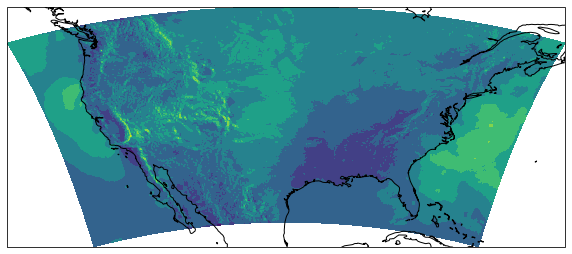

CPU times: user 2.44 s, sys: 381 ms, total: 2.82 s
Wall time: 34.8 s


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [115]:
%%time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Get rid of invalid values from dummy gridpoints in chunks that weren't actually 150x150
matrix = gust_climo_data[:1059, :1799]
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(chunk_index.longitude, chunk_index.latitude, matrix)
ax.coastlines()
plt.show()
plt.close()

## requirements.txt

python==3.8.10  
python-blosc==1.9.2   
cytoolz==0.11.0  
dask==2021.5.0  
dask_cloudprovider==2021.6.0  
lz4==3.1.3  
nomkl  
numpy==1.20.3  
pandas==1.0.1  
xarray==0.18.2  
s3fs==2021.5.0  
zarr==2.8.3  
boto3==1.16.52  
msgpack-python==1.0.2  
matplotlib  
cartopy  
metpy  